In [1]:
from keras.datasets import fashion_mnist

Using TensorFlow backend.


In [2]:
from keras.utils import np_utils
from keras import callbacks as cb
from keras.optimizers import Adam

In [3]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as img
%matplotlib inline

In [307]:
import helper.load_music as ld
import pygame
songs = ld.music_load(dir='Music_sample',length=8000)
song_test = songs[0].reshape(-1,2)
pygame.mixer.init(44100,-16,2)
sound = pygame.sndarray.make_sound(song_test)

In [4]:
label_data = {0:'T-shirt/top'
,1:'Trouser'
,2:'Pullover'
,3:'Dress'
,4:'Coat'
,5:'Sandal'
,6:'Shirt'
,7:'Sneaker'
,8:'Bag'
,9:'Ankle boot'}

In [177]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
x_train, x_test = np.expand_dims(x_train,3)/255., np.expand_dims(x_test,3)/255.
x_val, y_val = x_train[-5000:], y_train[-5000:]
x_train, y_train = x_train[:-5000], y_train[:-5000]
x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape

((55000, 28, 28, 1),
 (55000,),
 (5000, 28, 28, 1),
 (5000,),
 (10000, 28, 28, 1),
 (10000,))

In [178]:
from keras.layers import *
from keras.models import Sequential
from keras import regularizers as rg
from keras.preprocessing.image import ImageDataGenerator

In [286]:
'''
Random Erase, from 28x28 size we will randomly
25% of chance to be erased
set 0 for 4x4 - 6x6 area
Input: 3-d tensor WxHxC(1)
'''
imsize = 28
def random_erase(x):
    prob = np.random.rand(1)[0]
    out = x.copy()
    if prob > 0.75:
        width, height = np.random.randint(4,6,2)
        wst, hst = random.randint(0,imsize-width),random.randint(0,imsize-height)
        out[wst:wst+width, hst:hst+height] = 0
    return out

In [287]:
transform = ImageDataGenerator(
    featurewise_center = True,
    featurewise_std_normalization = True,
    horizontal_flip = True,
    preprocessing_function = random_erase
)

val_trans = ImageDataGenerator(
    featurewise_center = True,
    featurewise_std_normalization = True
)

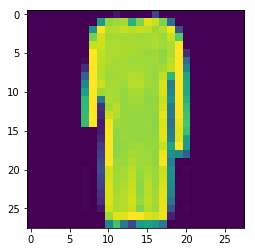

In [152]:
plt.imshow(random_erase(x_train[25][:,:,0]))

In [153]:
def show_image(im_data, label, sam_num):
    plt.title(label_data[label[sam_num]])
    plt.imshow(im_data[sam_num,:,:,0])

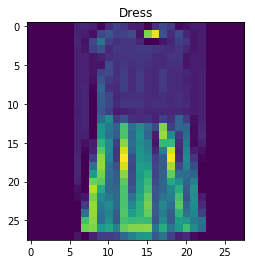

In [154]:
show_image(x_train, y_train, 251)

In [300]:
feature_layers = [
    Conv2D(32,(2,2),padding='valid',activation='relu',input_shape=(28,28,1)),
    BatchNormalization(),
    MaxPooling2D(),
    Conv2D(128,(2,2),padding='valid',activation='relu'),
    BatchNormalization(),
    MaxPooling2D(),
    Flatten()
]

classify_layer = [
    Dense(128,activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(64,activation='relu'),
    BatchNormalization(),
    Dropout(0.25),
    Dense(10,activation='softmax')
]

model = Sequential(feature_layers + classify_layer)

In [301]:
adam = Adam()
model.compile(optimizer=adam,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [302]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_57 (Conv2D)           (None, 27, 27, 32)        160       
_________________________________________________________________
batch_normalization_105 (Bat (None, 27, 27, 32)        128       
_________________________________________________________________
max_pooling2d_49 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_58 (Conv2D)           (None, 12, 12, 128)       16512     
_________________________________________________________________
batch_normalization_106 (Bat (None, 12, 12, 128)       512       
_________________________________________________________________
max_pooling2d_50 (MaxPooling (None, 6, 6, 128)         0         
_________________________________________________________________
flatten_25 (Flatten)         (None, 4608)              0         
__________

In [303]:
reduce_lr = cb.ReduceLROnPlateau(factor=0.4,patience=2)
save_model = cb.ModelCheckpoint('model/fashion2', monitor='val_loss',save_best_only=True)
#early_break = cb.EarlyStopping(patience=3)

In [304]:
transform.fit(x_train)
val_trans.fit(x_train)

In [305]:
onehot = np_utils.to_categorical
#train = model.fit(x_train, onehot(y_train), epochs=50, batch_size=100, validation_data=(x_val, onehot(y_val))
train = model.fit_generator(transform.flow(x_train, onehot(y_train), batch_size=100),epochs=50,
                            validation_data=val_trans.flow(x_val, onehot(y_val)),callbacks=[reduce_lr,save_model])
sound.play()

Epoch 1/50
550/550 [==============================] - 25s 46ms/step - loss: 0.5624 - acc: 0.8104 - val_loss: 0.3636 - val_acc: 0.8726
Epoch 2/50
550/550 [==============================] - 20s 37ms/step - loss: 0.3677 - acc: 0.8721 - val_loss: 0.2709 - val_acc: 0.9012
Epoch 3/50
550/550 [==============================] - 20s 36ms/step - loss: 0.3195 - acc: 0.8869 - val_loss: 0.2706 - val_acc: 0.9000
Epoch 4/50
550/550 [==============================] - 20s 36ms/step - loss: 0.2956 - acc: 0.8947 - val_loss: 0.2455 - val_acc: 0.9074
Epoch 5/50
550/550 [==============================] - 20s 36ms/step - loss: 0.2770 - acc: 0.9030 - val_loss: 0.2660 - val_acc: 0.9054
Epoch 6/50
550/550 [==============================] - 20s 36ms/step - loss: 0.2598 - acc: 0.9097 - val_loss: 0.3051 - val_acc: 0.8916
Epoch 7/50
550/550 [==============================] - 21s 38ms/step - loss: 0.2479 - acc: 0.9130 - val_loss: 0.2500 - val_acc: 0.9096
Epoch 8/50
550/550 [==============================] - 20s 36ms

In [309]:
sound.stop()

In [310]:
model.evaluate_generator(val_trans.flow(x_test, onehot(y_test)))

[0.21935722540616989, 0.92930000000000001]